# How to calculate and use filter functions for arbitrary controls
**Calculate the frequency-domain noise sensitivity of driven controls**

Boulder Opal allows the calculation of [filter functions](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/Graph/filter_function) as a way of estimating the sensitivity of an arbitrary control on a D-dimensional Hilbert space to time-dependent noise expressed in the frequency domain. In this guide we show how to define, calculate, and visualize filter functions obtained using Boulder Opal.

For more general information on the mathematical underpinning of the filter function framework see Section III.B. of [Software tools for quantum control: Improving quantum computer performance through noise and error suppression](https://arxiv.org/abs/2001.04060)

## Summary workflow
Usually, workflows involving filter function calculations include these four steps. A concrete example of these is in the next section.

### 1. Calculate filter functions
The operation `graph.filter_function` takes the following parameters:

* `control_hamiltonian`, which represents the system's Hamiltonian without noise,
* `noise_operator`, which represents the noise operator,
* `frequencies`, which is a list of frequencies where the filter function is to be sampled,
* `sample_count`, which can be used to adjust the precision of the calculation of the filter functions (setting it to `None` uses the exact filter function calculation),
* `projection_operator`, which projects into the subspace of interest, and
* `name`, which specifies name of the node.

This node can be evaluated through `boulderopal.execute_graph` and enabling [eager execution mode](https://docs.q-ctrl.com/boulder-opal/topics/improving-calculation-performance-in-graphs#try-eager-execution) leads to a boost in performance in the following example.
 

### 2. Calculate the frequency domain noise operators
The frequency domain noise operators are computed with `graph.frequency_domain_noise_operator`, taking the same arguments as `graph.filter_function`.

### 3. Visualize filter functions

After their calculation, the numerical values of the filter functions are stored as a dictionary `result["output"]["filter_function_name"]` (where `result` is the object returned by `boulderopal.execute_graph`). Each dictionary contains a key `inverse_powers` (our y coordinates), and if `sample_count` is not `None`, a key `uncertainties` (our y precision).

This information can be plotted using the `plot_filter_functions` function from the Q-CTRL Visualizer Python package.

The resulting graph represents the "noise admittance" of the control—where it is low, the noise is suppressed and where it is high, the noise is transmitted.  

### 4. Calculate control infidelity due to noise with filter functions

As explained in the reference documentation for `graph.filter_function`, the overlap integrals of the filter functions with the noise power spectral densities (PSDs) can be used to estimate the operational infidelity in the weak noise regime. 
If multiple sources of noise are present, the total infidelity $\mathcal{I}$  can be estimated by adding the contributions of each noise as represented by each filter function $F_k(f)$ and power spectral density $S_k(f)$ where $k$ is the index for the list of filter functions:

$$ \mathcal{I} \approx \sum_k \int_{-\infty}^\infty F_k (f) S_k (f) \,\, \mathrm{d}f. $$

With the filter functions we calculated previously, we can find the operational infidelity with respect to power spectral densities that we define. To do this, we just need to numerically calculate the overlap integrals, which can be done using the `np.trapz` NumPy function for composite trapezoidal rule integration.  In general this first-order approximation provides a good quantitative estimate for noise-infidelities $\lesssim 10\%$.  At higher noise strengths simple extensions may be used to approximate higher-order contributions (see [Experimental noise filtering by quantum control](https://www.nature.com/articles/nphys3115), [Supplementary information](https://static-content.springer.com/esm/art%3A10.1038%2Fnphys3115/MediaObjects/41567_2014_BFnphys3115_MOESM11_ESM.pdf)).

Note that if the pulses were not capable of perfectly creating the target X gates in the absence of noise, we should add the value of the noise-free infidelity, $\mathcal{I}_0$, to the calculation of the total infidelity: $ \mathcal{I} \approx \mathcal{I}_0 + \sum_k \int_{-\infty}^\infty F_k (f) S_k (f) \, \mathrm{d}f$. In the case of pulses that were predefined to generate the desired gate, $\mathcal{I}_0 \approx 0$.

## Example: Noise sensitivity of composite pulses applied to a single qubit

In this example, we will use filter functions to compare the sensitivity of different composite $\pi$-pulses to time-varying amplitude and dephasing noise. The Hamiltonian of the system we will be considering is:

$$
H(t) = \frac{1 + \beta_\Omega(t)}{2} \left[ \Omega(t) \sigma_- + \Omega^* (t) \sigma_+ \right] + \frac{\Delta(t)}{2} \sigma_z + \frac{\eta(t)}{2} \sigma_z,
$$

where $\Omega(t)$ is a time-dependent Rabi rate, $\beta_\Omega(t)$ is a fractional time-dependent amplitude fluctuation process, $\Delta(t)$ is a time-dependent clock shift, $\eta(t)$ is a small, slowly-varying stochastic dephasing noise process, and $\sigma_k$ are the Pauli matrices (with $\sigma_\pm = (\sigma_x \mp i \sigma_y)/2$).

Because there are two different noise channels we will be calculating two different filter functions for each control we study.  This will permit a direct comparison of how each control exhibits different responses to different noise channels.  We will compare the filter functions of each for a range of noise frequencies from $10^{-8} \Omega_\mathrm{max}$ to $\Omega_\mathrm{max}$, where $\Omega_\mathrm{max}/2\pi = 1~\mathrm{MHz}$ is the maximum Rabi frequency.

### Create the pulses

We will consider the following driven control schemes for the controllable Rabi and clock-shift terms:
* **Primitive**: sensitive to both dephasing and amplitude noise.
* **BB1**: suppresses amplitude noise.
* **CORPSE**: suppresses dephasing noise.
* **CORPSE in BB1**: suppresses both dephasing and amplitude noise.

These schemes are available from [Q-CTRL Open Controls](https://github.com/qctrl/open-controls) and described in the [reference documentation](https://docs.q-ctrl.com/open-controls/references/qctrl-open-controls/qctrlopencontrols).

We first set up Python objects representing the pulse, control, and noise. In the Hamiltonian used in this example, the drive corresponds to the term that contains the Rabi rate ($\Omega(t)$ and $\Omega^*(t)$), the shift corresponds to the term that contains the clock shift ($\Delta(t)$), and the drift corresponds to the dephasing term.

As we are interested in separately studying the robustness against amplitude noise in the complex-valued controls and in the dephasing term, we perform two separate filter function calculations for each scheme.

In [1]:
import numpy as np
import qctrlopencontrols as oc
import qctrlvisualizer as qv
import boulderopal as bo

In [2]:
# Define control parameters.
omega_max = 2 * np.pi * 1e6  # Hz
total_rotation = np.pi

# Define schemes for driven controls to compare.
pulses = [
    pulse_function(
        rabi_rotation=total_rotation,
        azimuthal_angle=0.0,
        maximum_rabi_rate=omega_max,
        name=pulse_name,
    )
    for pulse_name, pulse_function in [
        ("primitive", oc.new_primitive_control),
        ("BB1", oc.new_bb1_control),
        ("CORPSE", oc.new_corpse_control),
        ("CORPSE in BB1", oc.new_corpse_in_bb1_control),
    ]
]


def calculate_filter_functions(pulse, frequencies):
    """
    Calculate the filter functions associated to amplitude and dephasing noise
    for the given control scheme at the given frequencies.
    """
    graph = bo.Graph()

    # Define noiseless controls.
    drive_term = graph.hermitian_part(
        graph.pwc(
            durations=pulse.durations,
            values=pulse.rabi_rates * np.exp(1j * pulse.azimuthal_angles),
        )
        * graph.pauli_matrix("M")
    )
    shift_term = graph.pwc(durations=pulse.durations, values=pulse.detunings) * (
        graph.pauli_matrix("Z") / 2
    )

    duration = np.sum(shift_term.durations)
    drift_term = graph.constant_pwc_operator(
        duration=duration, operator=graph.pauli_matrix("Z") / 2
    )

    # The filter function of the amplitude noise.
    graph.filter_function(
        control_hamiltonian=shift_term + drive_term,
        noise_operator=drive_term,
        frequencies=frequencies,
        sample_count=3000,
        name="amplitude",
    )

    # The filter function of the dephasing noise.
    graph.filter_function(
        control_hamiltonian=drift_term + shift_term + drive_term,
        noise_operator=drift_term,
        frequencies=frequencies,
        sample_count=None,
        name="dephasing",
    )

    result = bo.execute_graph(
        graph=graph,
        output_node_names=["amplitude", "dephasing"],
        execution_mode="EAGER",
    )

    return result["output"]

### Calculate and visualize the filter functions

Here we calculate filter functions and set the frequencies in the array to be spaced logarithmically, because we will also be interested in plotting the filter functions on a log-log graph.

In [3]:
frequencies = omega_max * np.logspace(-8, 0, 1000, base=10)
scheme_results = {
    pulse.name: calculate_filter_functions(pulse, frequencies) for pulse in pulses
}

Your task (action_id="1828007") is queued.
Your task (action_id="1828007") has started.
Your task (action_id="1828007") has completed.
Your task (action_id="1828008") has started.
Your task (action_id="1828008") has completed.
Your task (action_id="1828009") has started.
Your task (action_id="1828009") has completed.
Your task (action_id="1828010") has started.
Your task (action_id="1828010") has completed.


#### Amplitude noise

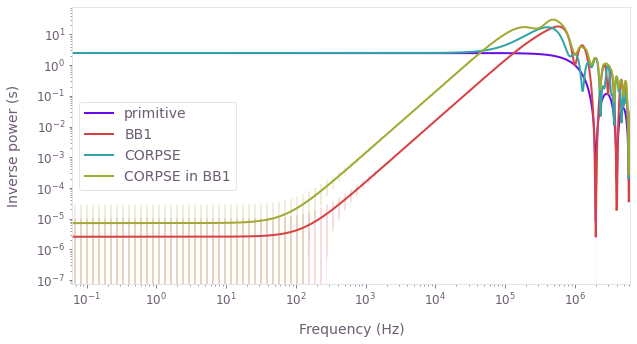

In [4]:
qv.plot_filter_functions(
    {
        pulse_name: filter_functions["amplitude"]
        for pulse_name, filter_functions in scheme_results.items()
    }
)

We see that the BB1 and CORPSE-in-BB1 pulses show small values of the filter function at low frequencies, corresponding to their known amplitude-noise-suppressing characteristics. CORPSE and primitive gates do not exhibit any suppression of amplitude noise.

#### Dephasing noise

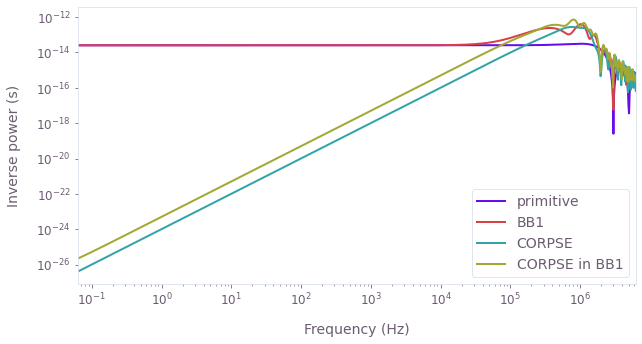

In [5]:
qv.plot_filter_functions(
    {
        pulse_name: filter_functions["dephasing"]
        for pulse_name, filter_functions in scheme_results.items()
    }
)

We see that the CORPSE and CORPSE-in-BB1 pulses show small values of the filter function at low frequencies, corresponding to their known dephasing-noise-suppressing characteristics. BB1 and primitive gates do not exhibit any suppression of dephasing noise.

### Calculate the infidelity with respect to noise power spectral densities using noise operators

The frequency domain noise operators are computed as part of the filter function calculation. They are available in the result samples when the `result_scope` parameter is set appropriately. In this case we have configured the filter function calculation for the dephasing noise to include the operators.

With these in hand we can calculate the expected infidelity of a control in the presence of noise channels exhibiting specific quantitative power spectra.  We define dimensionful power spectra below and compare the performance of the pulses.

In [6]:
pulse = [p for p in pulses if p.name == "primitive"][0]
frequencies = omega_max * np.logspace(-8, 0, 1000, base=10)

graph = bo.Graph()

# Define noiseless controls.
drive_term = graph.hermitian_part(
    graph.pwc(
        durations=pulse.durations,
        values=pulse.rabi_rates * np.exp(1j * pulse.azimuthal_angles),
    )
    * graph.pauli_matrix("M")
)
shift_term = graph.pwc(durations=pulse.durations, values=pulse.detunings) * (
    graph.pauli_matrix("Z") / 2
)

duration = np.sum(shift_term.durations)
drift_term = graph.constant_pwc_operator(
    duration=duration, operator=graph.pauli_matrix("Z") / 2
)

graph.frequency_domain_noise_operator(
    control_hamiltonian=drift_term + shift_term + drive_term,
    noise_operator=drift_term,
    frequencies=frequencies,
    sample_count=None,
    name="frequency_domain_noise_operator",
)

result = bo.execute_graph(
    graph=graph,
    output_node_names=["frequency_domain_noise_operator"],
    execution_mode="EAGER",
)

frequency_domain_noise_operator = result["output"]["frequency_domain_noise_operator"][
    "value"
]

print(f"Scheme: {pulse.name}")
print(f"Frequency domain noise operator at f = {frequencies[-1]:.2e} Hz")
print(frequency_domain_noise_operator[-1])

Your task (action_id="1828011") has completed.
Scheme: primitive
Frequency domain noise operator at f = 6.28e+06 Hz
[[-1.00946617e-08-2.11765689e-08j  1.60661849e-09+3.37035825e-09j]
 [-1.60661214e-09-3.37035300e-09j  1.00946617e-08+2.11765689e-08j]]


In [7]:
# Define amplitude noise power spectral density.
psd_amplitude = lambda frequency: 1e-2 / (frequency**2 + 1)

# Define dephasing noise power spectral density.
psd_dephasing = lambda frequency: 1e12 / (frequency**2 + 1)

for pulse_name, filter_functions in scheme_results.items():
    # Calculate overlap integral for amplitude noise.
    frequencies = filter_functions["amplitude"]["frequencies"]
    inverse_powers = filter_functions["amplitude"]["inverse_powers"]
    amplitude_infidelity = np.trapz(
        y=inverse_powers * psd_amplitude(frequencies), x=frequencies
    )

    # Calculate overlap integral for dephasing noise.
    frequencies = filter_functions["dephasing"]["frequencies"]
    inverse_powers = filter_functions["dephasing"]["inverse_powers"]
    dephasing_infidelity = np.trapz(
        y=inverse_powers * psd_dephasing(frequencies), x=frequencies
    )

    # Add contributions from the two noises.
    infidelity = amplitude_infidelity + dephasing_infidelity

    # Print results.
    print()
    print(f"Scheme: {pulse_name}")
    print(f"Infidelity due to amplitude noise: {amplitude_infidelity:.2e}")
    print(f"Infidelity due to dephasing noise: {dephasing_infidelity:.2e}")
    print(f"Total infidelity: {infidelity:.2e}")


Scheme: primitive
Infidelity due to amplitude noise: 3.72e-02
Infidelity due to dephasing noise: 3.82e-02
Total infidelity: 7.54e-02

Scheme: BB1
Infidelity due to amplitude noise: 7.50e-07
Infidelity due to dephasing noise: 3.82e-02
Total infidelity: 3.82e-02

Scheme: CORPSE
Infidelity due to amplitude noise: 3.73e-02
Infidelity due to dephasing noise: 7.50e-07
Total infidelity: 3.73e-02

Scheme: CORPSE in BB1
Infidelity due to amplitude noise: 2.84e-06
Infidelity due to dephasing noise: 2.19e-06
Total infidelity: 5.02e-06


### Summary

The plots and infidelities show that the BB1 controls perform better against (low-frequency) amplitude noise than the primitive $\pi$-pulse, but perform just like the primitive in the case of dephasing noise. This is expected, as BB1 is one of the *control-error-compensating driven controls*. The inverse is true of the pure CORPSE controls: they perform as poorly as the primitive against amplitude noise, but perform better against (low-frequency) dephasing noise. This behavior is expected as CORPSE is a *dephasing-error-compensating driven control*. Finally, the *dephasing-and-control-error-compensating driven control* CORPSE in BB1 performs better than the primitive for low-frequencies of both noises (albeit less so than the controls specialized for one specific kind of noise).

We have thus demonstrated how Boulder Opal can be used to characterize the sensitivity of different controls to time-dependent noise channels by calculating their corresponding filter functions.